In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

%matplotlib inline

print("Tensorflow version: ", tf.__version__)
print("Tensorflow Keras version: ", tf.keras.__version__)

Tensorflow version:  2.0.0
Tensorflow Keras version:  2.2.4-tf


## Load Data

- [IMDB](https://www.imdb.com/interfaces/) datasets: 
    - Contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).
    - These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are `balanced`, meaning they contain and equal number of positive and negative reviews.

In [2]:
def load_data():
    # The argument num_words=10000 
    # keeps the top 10,000 most frequently occurring words in the training data. 
    # The rare words are discarded to keep the size of the data manageable.
    imdb_dataset = tf.keras.datasets.imdb.load_data(num_words=10000)
    (x_train, y_train), (x_test, y_test) = imdb_dataset
    
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()

## Explore the data

- Each example is an array of integers representing the words of the movie review.
- Each labele is an integer value of rither 0 or 1.
    - 0: negative review
    - 1: positive review
   
- Movie reviews may be different lengths.

In [3]:
print("Training entries: {}, labels: {}".format(len(x_train), len(y_train)))

print("First review length: ", len(x_train[0]))
print("Second review length: ", len(x_train[1]))

print()
print(x_train[0])

Training entries: 25000, labels: 25000
First review length:  218
Second review length:  189

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103

## Preprocess the data: Convert the integers back to words

In [ ]:
# A dictionary mapping words to an integer index
word_index = tf.keras.datasets.imdb.get_word_index()
word_index

In [ ]:
# The first indices are reserved
word_index = {k: (v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) 

print(reverse_word_index)

def decode_review(text):
    #  dict.get(): returns a value for the given key. 
    #              If key is not available then returns default value.
    #              default value is `None`.
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [6]:
decode_review(x_train[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Prepare the data

The reivews-the array of integers-must be converted to `tensors` before fed into the neural network.

This conversion can be done a coiple ways:

- One-hot encoding:

    For example, the sequence [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones.Then, make this the first layer in our neural network-a Denselayer-that can handle floating point vector data.
    
    * This approch is memory intensive, though, requiring a `num_words * num_reviews` size matrix.


- Pad the arrays:

    So they all have the same length, then create an integer tensor of shape `max_length * num_reviews`.
    
    * We can use an embedding layer capable of handling this shape as the first layer in our neural network.


In this tutorial, we will use the second approach.

[pad_sequences](https://keras.io/preprocessing/sequence/#pad_sequences)

In [7]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256)

x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256)

print("First review length: ", len(x_train[0]))
print("Second review length: ", len(x_train[1]))
print(x_train.shape)

print()
print(x_train[0])

First review length:  256
Second review length:  256
(25000, 256)

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480

## Create a validation set

In [8]:
x_valid = x_train[:10000]
x_train = x_train[10000:]

y_valid = y_train[:10000]
y_train = y_train[10000:]

print("training set: {}".format(x_train.shape[0]))
print("validation set: {}".format(x_valid.shape[0]))

training set: 15000
validation set: 10000


## Build the model

In [9]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = tf.keras.Sequential()

model.add(Embedding(vocab_size, 16))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

## Train the model

In [11]:
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 99us/sample - loss: 0.6919 - acc: 0.5255 - val_loss: 0.6901 - val_acc: 0.5318
Epoch 2/40
15000/15000 [==============================] - 1s 34us/sample - loss: 0.6867 - acc: 0.6027 - val_loss: 0.6835 - val_acc: 0.7222
Epoch 3/40
15000/15000 [==============================] - 1s 34us/sample - loss: 0.6768 - acc: 0.7297 - val_loss: 0.6714 - val_acc: 0.7141
Epoch 4/40
15000/15000 [==============================] - 0s 33us/sample - loss: 0.6581 - acc: 0.7521 - val_loss: 0.6478 - val_acc: 0.7631
Epoch 5/40
15000/15000 [==============================] - 1s 34us/sample - loss: 0.6267 - acc: 0.7863 - val_loss: 0.6135 - val_acc: 0.7811
Epoch 6/40
15000/15000 [==============================] - 1s 34us/sample - loss: 0.5840 - acc: 0.8095 - val_loss: 0.5716 - val_acc: 0.7982
Epoch 7/40
15000/15000 [==============================] - 1s 34us/sample - loss: 0.5350 - acc: 0.8247 - val_loss: 0.

## Evaluate the model

In [12]:
results = model.evaluate(x_test, y_test, verbose=2)
print("Test Acc: ", results[1])

25000/1 - 1s - loss: 0.3205 - acc: 0.8699
Test Acc:  0.86988


## Create a graph of accuracy and loss over time

`model.fit()` returns a History object that contains a dictionary with everything that happened during training:

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

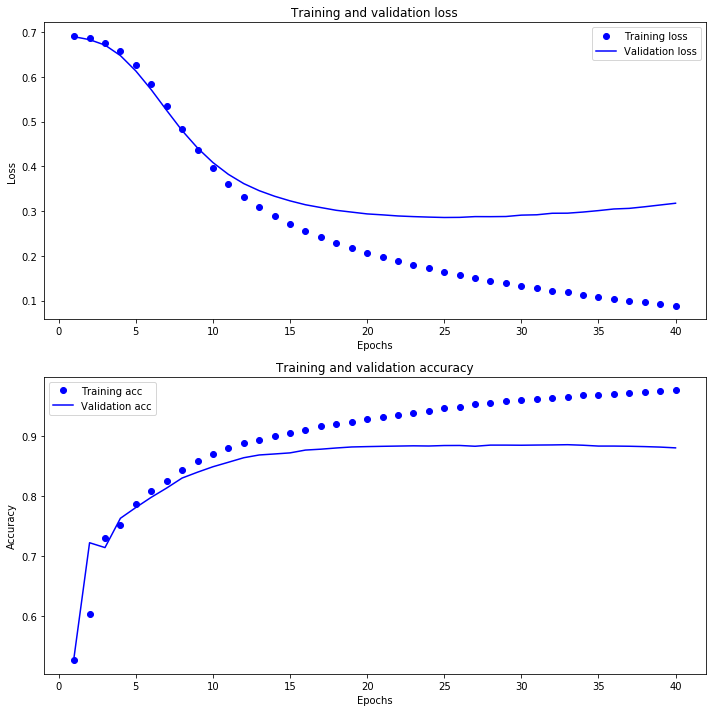

In [14]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()